<a href="https://colab.research.google.com/github/Ali-Ukperaj/MonteCarloIDP/blob/main/MonteCarlo1.1_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title <b>Prerequisite Setup</b>
## Import Dependencies
import copy
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
import os
import warnings
warnings.filterwarnings("ignore")

if os.path.exists('AA_properties') == False:
  # Download necessary files
  github_folder = 'https://github.com/Dignon-Lab/Monte-Carlo'
  os.system(f"git clone {github_folder} && mv Monte-Carlo/* Monte-Carlo/.. && rm -r Monte-Carlo")

!pip install -r requirements.txt --upgrade-strategy only-if-needed | grep -v 'already satisfied'

# Delta G Dependencies
import pandas as pd
from predictor import *
import joblib

# Create output folders
if os.path.exists('Run_Data') == False:
  os.makedirs('Run_Data', exist_ok=True)
  os.makedirs('Run_Data/Data', exist_ok=True)
  os.makedirs('Run_Data/Plots', exist_ok=True)

# Define parameter functions
# Calculate SCD
def SCD_calc(Seq):
    Length = len(Seq)
    ## Calculate charge for each residue
    q_Sequence = np.array([charge[Seq[i]] for i in range(Length)])

    ## From sequences, calculate the sequence charge decoration (SCD)
    SCD = 0
    for i in range(1, Length):
        SCD += ((q_Sequence[i:] * q_Sequence[:-i]) * np.sqrt(i)).sum()
    SCD /= Length
    return SCD

# Calculate SHD
def SHD_calc(Seq):
    Length = len(Seq)
    ## Calculate hydropathy for each residue
    h_Sequence = np.array([hydropathy[Seq[i]] for i in range(Length)])

    ## From sequences, calculate the sequence hydrophobicity decoration (SHD)
    SHD = 0
    for i in range(1, Length):
        SHD += ((h_Sequence[i:] + h_Sequence[:-i]) / i).sum()
    SHD /= Length
    return SHD

# Calculate SAD
def SAD_calc(Seq):
    Length = len(Seq)
    ## Calculate aromaticity for each residue
    a_Sequence = np.array([bAromatic[Seq[i]] for i in range(Length)])

    ## From sequences, calculate the sequence aromatic decoration (SAD)
    SAD = 0
    for i in range(1, Length):
        SAD += ((a_Sequence[i:] * a_Sequence[:-i]) / i).sum()
    SAD /= Length
    return SAD

# Calculate delta(G)
def delta_G(seq,features,residues,nu_file):
    X = X_from_seq(seq,features,residues=residues,charge_termini=CHARGE_TERMINI,nu_file=nu_file)
    ys = models['dG'].predict(X)
    ys_m = np.mean(ys)
    return ys_m #kT

# Call previous 4 functions to calculate those paramaters, calculate composition RMSD,
# then place all of them into a single dictionary output variable
def param_calc(Seq):
    Length = len(Seq)
    # Define SCD, SHD, SAD, delta(G), and composition RMSD of the sequence
    if InputSCD == 'None':
        SCD = 'None'
    else:
        SCD = SCD_calc(Seq)

    if InputSHD == 'None':
        SHD = 'None'
    else:
        SHD = SHD_calc(Seq)

    if InputSAD == 'None':
        SAD = 'None'
    else:
        SAD = SAD_calc(Seq)

    if InputdelG == 'None':
        delG = 'None'
    else:
        delG = delta_G(Seq,features,residues,nu_file)

    # Define Composition RMSD
    if InputComp == 'None':
        Comp_RMSD = 'None'
    else:
        # Calculate fraction of each amino in the sequence tested
        Seq_Comp = {amino: ((len(np.where(np.array(Seq) == amino)[0].tolist())) / (Length)) for amino in Amino_1}
        Comp_RMSD = 0
        for amino_name, frac_amino in Composition.items():
            # Uses common dictionary keys (Amino 1-Letter Abbrev.) to compare the fraction of aminos in ideal vs input sequence
            Comp_RMSD += (Seq_Comp[amino_name] - frac_amino)**2
        Comp_RMSD = (np.sqrt(Comp_RMSD))/len(Amino_1)

    params = {'SCD': SCD,
              'SHD': SHD,
              'SAD': SAD,
              'delG': delG,
              'Comp': Comp_RMSD}
    return params

# Calculate the "energy" of a single sequence by first calling the "params" function to determine parameters
def energy_func(Seq):
    # Params is array with following format: [SCD, SHD, SAD, delG]
    params = param_calc(Seq)
    energy = 0
    for key, (goal, weight) in Goals.items():
        if params[key] != 'None':
            energy += weight*(abs(params[key] - goal))

    # create temporary array that stores fraction of energy
    fract_energy = {}
    tot_energy = {}
    for key, (goal, weight) in Goals.items():
        if params[key] != 'None':
            fract_energy[key] = (weight*(abs(params[key] - goal)))/energy
            tot_energy[key] = (weight*(abs(params[key] - goal)))

    return energy, fract_energy, tot_energy

def energyTracking(SeqOld, SeqNew):
    ParKeys = ["SCD", "SHD", "SAD", "delG", "Comp"]
    _, fracEnOld, totEnOld = energy_func(SeqOld)
    _, fracEnNew, totEnNew = energy_func(SeqNew)

    enChange = np.full(len(ParKeys), np.nan, dtype=float)
    enFrac = np.full(len(ParKeys), np.nan, dtype=float)
    enTot = np.full(len(ParKeys), np.nan, dtype=float)

    paramCount = 0
    for key, (goal, weight) in Goals.items():
        if params[key] != 'None':
            enChange[paramCount] = totEnNew[key] - totEnOld[key]
            enFrac[paramCount] = fracEnOld[key]
            enTot[paramCount] = totEnOld[key]
        paramCount += 1
    return enChange, enFrac, enTot

# Calculate the Metropolis criterion by inputting two sequences, then using the energy function to determine the energy of each
def Metropolis(Seq0, SeqMut):
    k_B = 1
    T = 10**(-2)
    energy0 = energy_func(Seq0)[0]
    energyMut = energy_func(SeqMut)[0]
    deltaE = energyMut - energy0
    Metrop = np.exp(-deltaE/(k_B*T))
    return Metrop

####################  Type of alterations  ####################
def seq_mut(Seq):
    # determines place in chain where mutation will occur
    idx = np.random.randint(0, len(Seq))  # integer that will be the index for mutated residue in sequence
    Seq_New = copy.deepcopy(Seq[:])  # Create new sequence to not affect original input sequence
    # create new Amino list that doesn't include residue currently there
    Amino_1_New = [res for res in Amino_1 if res != Seq[idx]]
    Seq_New[idx] = np.random.choice(Amino_1_New)  # assign random residue to new sequence in determined spot
    return Seq_New

def seq_swap(Seq):
    idx1 = np.random.randint(0, len(Seq))  # integer that will be the index for the first swapped residue in the sequence
    Amino_idx1 = Seq[idx1]
    idx2 = np.random.randint(0, len(Seq))  # integer that will be the index for the second swapped residue in the sequence
    Amino_idx2 = Seq[idx2]
    Seq_New = copy.deepcopy(Seq[:])  # Create new sequence to not affect original input sequence
    # Swap residues at determined locations
    Seq_New[idx1] = Amino_idx2
    Seq_New[idx2] = Amino_idx1
    return Seq_New

# Function that will shuffle a variable length of the sequence ranging from (3, N)
def seq_shuf(Seq):
    # Input sequence MUST be a numpy array containing a list. This is because the sequences will be indexed with another list and
    # this functionality is only possible with a numpy array
    copyShuf = copy.deepcopy(Seq[:])
    lenseq = len(Seq)
    shuf_size = np.random.randint(3, lenseq)
    shuf_start = np.random.randint(0, lenseq)
    shuf_indices = np.linspace(shuf_start, shuf_start+shuf_size-1, shuf_size)
    indices = []
    # conditional that makes indices periodic by catching out of bounds indices
    for ind in shuf_indices:
        if ind > (lenseq-1):
            indices.append(int(ind)-int(lenseq))
        else:
            indices.append(int(ind))
    Seq_New = copy.deepcopy(copyShuf[:])
    Seq_New[indices] = np.random.permutation(copyShuf[indices])
    return Seq_New
###############################################################


#################### Choosing Alteration ######################
def alteration(mutAmt, swpAmt, shfAmt, Seq):
    lowbound = 0
    upbound = mutAmt + swpAmt + shfAmt
    coin_flip = np.random.randint(lowbound, upbound)
    if (coin_flip >= lowbound) & (coin_flip < (lowbound + mutAmt)):
        New_Seq = seq_mut(Seq)
        seqIdentifier = 0  # variable used to identify what moveset will be applied
    elif (coin_flip >= (lowbound + mutAmt)) & (coin_flip < (lowbound + mutAmt + swpAmt)):
        New_Seq = seq_swap(Seq)
        seqIdentifier = 1
    elif (coin_flip >= (lowbound + mutAmt + swpAmt)) & (coin_flip < (lowbound + mutAmt + swpAmt + shfAmt)):
        New_Seq = seq_shuf(Seq)
        seqIdentifier = 2
    return New_Seq, seqIdentifier
###############################################################

# Estimated Parameter Stats Functions
def SCD_stats(Seq, Length):
    q_Sequence = np.array([charge[Seq[i]] for i in range(Length)])
    q_Net = q_Sequence.sum()
    NCPR = q_Net / Length
    fplus = (q_Sequence > 0).mean()
    fminus = (q_Sequence < 0).mean()
    FCR = fplus + fminus
    # Fitted functions for estimating the mean and standard deviation SCD for the sequences fixed-composition ensemble
    est_meanSCD = (0.25425) * (Length ** (1.50780)) * (NCPR ** 2)
    est_stdSCD = (0.05306 * (Length ** (1.12164))) * FCR * ((NCPR ** 2) - (1.36401 * (NCPR ** 4)) + (Length ** (-0.39905)))
    return est_meanSCD, est_stdSCD

def SHD_stats(Seq, Length):
    h_Sequence_orig = np.array([hydropathy[Seq[i]] for i in range(Length)])
    mean_hyd = np.mean(h_Sequence_orig)
    std_hyd = np.std(h_Sequence_orig)
    # Fitted functions for estimating the mean and standard deviation SHD for the sequences fixed-composition ensemble
    est_meanSHD = (2.7610) * (mean_hyd) * (Length ** (0.2354))
    est_stdSHD = (0.65 * (Length ** (-0.45922))) * std_hyd
    return est_meanSHD, est_stdSHD

def SAD_stats(Seq, Length):
    a_Sequence = np.array([bAromatic[Seq[i]] for i in range(Length)])
    FAR = (a_Sequence > 0).mean()
    std_arom = np.std(a_Sequence)
    # Fitted functions for estimating the mean and standard deviation SAD for the sequences fixed-composition ensemble
    est_meanSAD = (1.6188) * (FAR ** (2.0390)) * (Length ** (0.2110))
    est_stdSAD = (1.4177) * (std_arom ** (2.4598)) * (Length ** (-0.4404))
    return est_meanSAD, est_stdSAD

# Param Weights Calc
def SCD_WeightFunc(Seq, Length):
    est_stdSCD = SCD_stats(Seq, Length)[1]
    WtSCD = 1/est_stdSCD
    return WtSCD

def SHD_WeightFunc(Seq, Length):
    est_stdSHD = SHD_stats(Seq, Length)[1]
    WtSHD = 1/est_stdSHD
    return WtSHD

def SAD_WeightFunc(Seq, Length):
    est_stdSAD = SAD_stats(Seq, Length)[1]
    WtSAD = 1/est_stdSAD
    return WtSAD

## Define function used for checking the conditionals of the loop
def check_conditions():
    # Determine form of conditionals
    if len(saved_Keys) == 1:
        idx1 = saved_Keys[0]
        cond = (abs(params[idx1] - Goals[idx1][0])) > Intervals_Dict[idx1]
    elif len(saved_Keys) == 2:
        idx1, idx2 = saved_Keys[0], saved_Keys[1]
        cond = (((abs(params[idx1] - Goals[idx1][0])) > Intervals_Dict[idx1]) or
                ((abs(params[idx2] - Goals[idx2][0])) > Intervals_Dict[idx2]))
    elif len(saved_Keys) == 3:
        idx1, idx2, idx3 = saved_Keys[0], saved_Keys[1], saved_Keys[2]
        cond = ((((abs(params[idx1] - Goals[idx1][0])) > Intervals_Dict[idx1]) or
                ((abs(params[idx2] - Goals[idx2][0])) > Intervals_Dict[idx2])) or
                ((abs(params[idx3] - Goals[idx3][0])) > Intervals_Dict[idx3]))
    elif len(saved_Keys) == 4:
        idx1, idx2, idx3, idx4 = saved_Keys[0], saved_Keys[1], saved_Keys[2], saved_Keys[3]
        cond = (((((abs(params[idx1] - Goals[idx1][0])) > Intervals_Dict[idx1]) or
                 ((abs(params[idx2] - Goals[idx2][0])) > Intervals_Dict[idx2])) or
                ((abs(params[idx3] - Goals[idx3][0])) > Intervals_Dict[idx3])) or
                ((abs(params[idx4] - Goals[idx4][0])) > Intervals_Dict[idx4]))
    elif len(saved_Keys) == 5:
        idx1, idx2, idx3, idx4, idx5 = saved_Keys[0], saved_Keys[1], saved_Keys[2], saved_Keys[3], saved_Keys[4]
        cond = ((((((abs(params[idx1] - Goals[idx1][0])) > Intervals_Dict[idx1]) or
                  ((abs(params[idx2] - Goals[idx2][0])) > Intervals_Dict[idx2])) or
                 ((abs(params[idx3] - Goals[idx3][0])) > Intervals_Dict[idx3])) or
                ((abs(params[idx4] - Goals[idx4][0])) > Intervals_Dict[idx4])) or
                ((abs(params[idx5] - Goals[idx5][0])) > Intervals_Dict[idx5]))
    return cond

## Define general information needed to run processes
# General residue information
Amino_1 = ['A','R','N','D','C','Q','E','G','H','I','L','K','M', 'F','P','S','T','W','Y','V']
hydropathy = np.loadtxt('AA_properties/Urry.dat', dtype=object)
hydropathy[:, 1] = hydropathy[:, 1].astype(float)
hydropathy = dict(hydropathy)
charge = np.loadtxt('AA_properties/charges.dat', dtype=object)
charge[:, 1] = charge[:, 1].astype(float)
charge = dict(charge)
bAromatic = {"A": 0, "C": 0, "D": 0, "E": 0, "F": 1, "G": 0, "H": 1, "I": 0, "K": 0, "L": 0, "M": 0, "N": 0, "P": 0, "Q": 0, "R": 0,
             "S": 0, "T": 0, "V": 0, "W": 1, "Y": 1}

# Information needed for delta(G) calculation
residues = pd.read_csv('residues.csv').set_index('one')   # residue.csv must be in the same directory as this script
nu_file = 'svr_model_nu.joblib'                           # svr_model_nu.joblib must be in the same directory as this script
features = ['mean_lambda', 'faro', 'shd', 'ncpr', 'fcr', 'scd', 'ah_ij','nu_svr']
models = {}
models['dG'] = joblib.load(f'model_dG.joblib')          # model_dG.joblib must be in the same directory as this script

If looking to make a specific sequence more prone to phase separation or create a phase separating version with similar composition to a given protein, input a specific reference sequence with the desired length you’d like your final protein sequence to be.

If this does not apply to you, leave the input blank and the algorithm will randomly generate a starting sequence that is favorable to your desired properties. The main difference here is that in the later option there is no need to maintain compositional integrity when making alterations to the sequence.


In [ ]:
#@title <b>Input Recommendations with Input Sequence</b>

#@markdown Input a reference sequence and an estimated range of each patterning parameters (SCD, SHD, & SAD) will be returned. This range will estimate 3 standard deviations below and above the estimated average of the fixed-composition ensemble distribution. This step can be skipped if recommendation is not desired.
refSeq = "MESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRRGGAGGGGYRRGGGNSGGGGGGGYDRGYNDNRDDRDNRGGSGGYGRDRNYEDRGYNGGGGGGGNRGYNNNRGGGGGGYNRQDRGDGGSSNFSRGGYNNRDEGSDNRGSGRSYNNDRRDNGGDG" # @param {"type":"string","placeholder":""}
if refSeq != "None":
    refSeq = list(refSeq)
    refSeqLen = len(refSeq)
estSCDmean, estSCDstd = SCD_stats(refSeq, refSeqLen)
estSHDmean, estSHDstd = SHD_stats(refSeq, refSeqLen)
estSADmean, estSADstd = SAD_stats(refSeq, refSeqLen)
print(f"Range of SCD values: [{estSCDmean - 3*estSCDstd:.3f}, {estSCDmean + 3*estSCDstd:.3f}]\nRange of SHD values: [{estSHDmean - 3*estSHDstd:.3f}, {estSHDmean + 3*estSHDstd:.3f}]\nRange of SAD values: [{estSADmean - 3*estSADstd:.3f}, {estSADmean + 3*estSADstd:.3f}]\n")

Range of SCD values: [-1.325, 2.152]
Range of SHD values: [5.196, 5.251]
Range of SAD values: [0.009, 0.043]



In [ ]:
#@title <b>Inputs</b>

## INPUT a reference sequence and/or desired length of output/resultant sequence

#@markdown Input the sequence you'd like to optimze and/or the desired length of your resultant sequence. You must have at least one input for "Ideal_Seq" or "DesLength". If you do not have a preference for one parameter, write None.
# Optionally determine a reference input sequence (if none, composition RMSD goal does not exist)
# Insert Ideal Input or "None" if None
Ideal_Seq = "None" # @param {"type":"string","placeholder":""}

if Ideal_Seq != "None":
    Ideal_Seq = list(Ideal_Seq)
    Inp_SeqLength = len(Ideal_Seq)

# Insert desired length of output/goal sequence. MUST have (atleast) either an input reference sequence OR input desired length
DesLength = "20" # @param {"type":"string","placeholder":"None"}

if (DesLength == "None") & (Ideal_Seq == "None"):
    print("WARNING: You must enter an input for DesLength, IdealSeq, or both. They cannot both be \"None\".")

# If desired length not explicitly specified, assume same size as input reference sequence.
if DesLength == "None":
    DesLength = Inp_SeqLength
else:
    DesLength = int(DesLength)

# Define Comp_Goal and composition of sequence depending on input Ideal_Seq
if Ideal_Seq == "None":
    Composition = 'None'
    Comp_Goal = 'None'
    Inp_SeqLength = DesLength
else:
    # Create a dictionary composition by finding the fraction of each amino acid in the reference sequence (n_amino/n_total)
    Composition = {amino: (len(np.where(np.array(Ideal_Seq) == amino)[0].tolist()))/(Inp_SeqLength) for amino in Amino_1}
    Comp_Goal = 0

#@markdown Input desired values of parameters for optimized sequence. If you do not want a parameter to be included in optimization, write None.
## INPUT parameter goal values.
SCD_Goal = "-5" # @param {"type":"string","placeholder":"1"}
SHD_Goal = "5.327" # @param {"type":"string","placeholder":"1"}
SAD_Goal = "0.031" # @param {"type":"string","placeholder":"1"}
delG_Goal = "-8" # @param {"type":"string","placeholder":"1"}

if SCD_Goal != "None":
    SCD_Goal = float(SCD_Goal)
if SHD_Goal != "None":
    SHD_Goal = float(SHD_Goal)
if SAD_Goal != "None":
    SAD_Goal = float(SAD_Goal)
if delG_Goal != "None":
    delG_Goal = float(delG_Goal)
Goal_Array = [SCD_Goal, SHD_Goal, SAD_Goal, delG_Goal, Comp_Goal]

#@markdown Input parameter weights (how important each parameter is to your goal). If you do not want to optimize for a given parameter, input None.
# Recommended weights are calculated for each parameter, so if you would like to run purely based on that, leave parameter weight as 1.
SCD_InputWeight = "1" # @param ["None","1","2","3"]
SHD_InputWeight = "1" # @param ["None","1","2","3"]
SAD_InputWeight = "1" # @param ["None","1","2","3"]
delG_InputWeight = "1" # @param ["None","1","2","3"]
Comp_InputWeight = "None" # @param ["None","1","2","3"]

if (Ideal_Seq == "None") & (Comp_InputWeight != "None"):
    print('WARNING: If there is no reference sequence and Ideal_Seq is set to \"None\", Comp_InputWeight must also be set to \"None\".')

if SCD_InputWeight != "None":
    InputSCD = int(SCD_InputWeight)
else:
    InputSCD = 'None'
if SHD_InputWeight != "None":
    InputSHD = int(SHD_InputWeight)
else:
    InputSHD = 'None'
if SAD_InputWeight != "None":
    InputSAD = int(SAD_InputWeight)
else:
    InputSAD = 'None'
if delG_InputWeight != "None":
    InputdelG = int(delG_InputWeight)
else:
    InputdelG = 'None'
if Comp_InputWeight != "None":
    InputComp = int(Comp_InputWeight)
else:
    InputComp = 'None'

InputWeights = [InputSCD, InputSHD, InputSAD, InputdelG, InputComp]
InputWeightDictionary = {'SCD': InputSCD, 'SHD': InputSHD, 'SAD': InputSAD, 'delG': InputdelG, 'Comp': InputComp}

ParamKey = ["SCD","SHD","SAD","delG","CompRMSD"]
for [indicWt, wts] in enumerate(InputWeights):
    if (wts == "None") ^ (Goal_Array[indicWt] == "None"):
        print(f"Error ({ParamKey[indicWt]}): If not interested in a parameter, both your goal value and weight for that parameter must be None")

#@markdown Input desired move set frequencies and ratios. If you do not want a moveset to be used, input None.
mutRatio = "1" # @param ["None","1","2","3","4","5"]
swpRatio = "1" # @param ["None","1","2","3","4","5"]
shfRatio = "1" # @param ["None","1","2","3","4","5"]
if mutRatio != "None":
    mutRatio = int(mutRatio)
else:
    mutRatio = 0
if swpRatio != "None":
    swpRatio = int(swpRatio)
else:
    swpRatio = 0
if shfRatio != "None":
    shfRatio = int(shfRatio)
else:
    shfRatio = 0

#@markdown Input the maximum number of iterations you'd like to run the for.
desired_cycles = 100 # @param {"type":"integer", "placeholder":"1000"}

#@markdown Indicate if you'd like to enable advanced statistics. This will supplement outputs to the Monte Carlo by additionally including a total loss trajectory figure; energy decomposition figure; and data files on the energy and parameter movements throughout the Monte Carlo run.
advanced_stats = True # @param {type:"boolean"}

In [ ]:
#@title <b>Calculate Final Variables Needed and Run Loop</b>

## Calculate recommended weights based on derived formulas and then determine FINAL weights based on these and input weights
if Ideal_Seq == 'None':
    SCD_Weight, SHD_Weight, SAD_Weight, delG_Weight, Comp_Weight = 1, 1, 1, 1, 1
else:
    SCD_Weight, SHD_Weight, SAD_Weight, delG_Weight, Comp_Weight = (SCD_WeightFunc(Ideal_Seq, Inp_SeqLength), SHD_WeightFunc(Ideal_Seq, Inp_SeqLength), SAD_WeightFunc(Ideal_Seq, Inp_SeqLength), 1/10, 1/np.sqrt(2))
CalcWeights = [SCD_Weight, SHD_Weight, SAD_Weight, delG_Weight, Comp_Weight]

# Initialize final weights
Weights = [0, 0, 0, 0, 0]
# Use input weight ratios to balance the calculated and input weights & define Goals + Intervals
for count, inp in enumerate(InputWeights):
    if inp == 'None':
        Weights[count] = 0
    else:
        Weights[count] = inp*CalcWeights[count]

## Set intervals for each parameter (range within which a parameter has arrived at its goal)
Intervals = [0, 0, 0, 0, 0]
for count, goal in enumerate(Goal_Array):
    if goal == 0:
        Intervals[count] = 0.0005
    elif goal == "None":
        Intervals[count] = "None"
    else:
        Intervals[count] = abs(goal*0.0005)

Intervals_Dict = {
    'SCD': Intervals[0],
    'SHD': Intervals[1],
    'SAD': Intervals[2],
    'delG': Intervals[3],
    'Comp': Intervals[4]}

# Account for parameters that a user may not want to optimize for
# Save keys where Interval != None
saved_Keys = []
for key, inte in InputWeightDictionary.items():
    if inte != "None":
        saved_Keys.append(key)

# Place parameter goals and their associated weights in a dictionary format
Goals = {
    'SCD': [SCD_Goal, Weights[0]],
    'SHD': [SHD_Goal, Weights[1]],
    'SAD': [SAD_Goal, Weights[2]],
    'delG': [delG_Goal, Weights[3]],
    'Comp': [Comp_Goal, Weights[4]]}

## Determine a starting sequence by minimizing the energy function out of 100 randomly generated sequences
# Essentially, if you want to keep composition exactly the same as your ideal sequence, don't randomly generate starting sequence
if ((mutRatio == 0)   &   ((DesLength == 'None')  or  (Ideal_Seq != "None") & (DesLength == len(Ideal_Seq)))):
    Seq = np.array(list(Ideal_Seq))

    SEQUENCE = Ideal_Seq.copy()
    SEQUENCE = str(SEQUENCE)
    SEQUENCE = SEQUENCE.replace('[','').replace(']','').replace(',','').replace('\'','').replace(' ','')
    CHARGE_TERMINI = True
    seq = SEQUENCE
    if " " in seq:
        seq = ''.join(seq.split())
        print('Blank character(s) found in the provided sequence. Sequence has been corrected, but check for integrity.')
elif Ideal_Seq != "None":
    MinEnergySeq = np.empty(shape=[100, 2], dtype=object)
    for i in range(100):
        SeqRand = np.random.choice(Amino_1, DesLength)
        energyRand = energy_func(SeqRand)
        MinEnergySeq[i] = ["".join(SeqRand), energyRand]
    # Sequence with the minimum energy
    Seq = np.array(list(MinEnergySeq[np.argmin(MinEnergySeq[:, 1], axis=0), 0]))

    # Initialize delG calculator with minimum energy sequence since no reference sequence given
    SEQUENCE = Seq.copy()
    SEQUENCE = str(SEQUENCE)
    SEQUENCE = SEQUENCE.replace('[','').replace(']','').replace(',','').replace('\'','').replace(' ','')
    CHARGE_TERMINI = True
    seq = SEQUENCE
    if " " in seq:
        seq = ''.join(seq.split())
        print('Blank character(s) found in the provided sequence. Sequence has been corrected, but check for integrity.')
else:
    # save user delG input value, then set that and CompRMSD input to none so we can avoid it in the initial energy minimization
    saveInputdelG = copy.deepcopy(InputdelG)
    InputdelG, InputComp = 'None', 'None'

    # Initialize array for saving pairs of sequences and their respective "energies"
    MinEnergySeq = np.empty(shape=[100, 2], dtype=object)
    for i in range(100):
        SeqRand = np.random.choice(Amino_1, DesLength)
        energyRand = energy_func(SeqRand)
        MinEnergySeq[i] = ["".join(SeqRand), energyRand]
    # Sequence with the minimum energy
    Seq = np.array(list(MinEnergySeq[np.argmin(MinEnergySeq[:, 1], axis=0), 0]))

    # set input delG and compRMSD value back to user input
    InputdelG = saveInputdelG

    # Initialize delG calculator with minimum energy sequence since no reference sequence given
    SEQUENCE = Seq.copy()
    SEQUENCE = str(SEQUENCE)
    SEQUENCE = SEQUENCE.replace('[','').replace(']','').replace(',','').replace('\'','').replace(' ','')
    CHARGE_TERMINI = True
    seq = SEQUENCE
    if " " in seq:
        seq = ''.join(seq.split())
        print('Blank character(s) found in the provided sequence. Sequence has been corrected, but check for integrity.')

# Use minimum energy sequence to calculate weights using normalization schemes for patterning parameters
if Ideal_Seq == 'None':
    SCD_Weight, SHD_Weight, SAD_Weight, delG_Weight, Comp_Weight = (SCD_WeightFunc(Seq, DesLength), SHD_WeightFunc(Seq, DesLength), SAD_WeightFunc(Seq, DesLength), 1/10, 1/np.sqrt(2))
    CalcWeights = [SCD_Weight, SHD_Weight, SAD_Weight, delG_Weight, Comp_Weight]
    # Recalculate final weights with new starting sequence
    Weights = [0, 0, 0, 0, 0]
    for count, inp in enumerate(InputWeights):
        if inp == 'None':
            Weights[count] = 0
        else:
            Weights[count] = inp * CalcWeights[count]


# Set starting sequence's parameters
params = param_calc(Seq)
Seq_Comp = {amino: ((len(np.where(np.array(Seq) == amino)[0].tolist())) / (DesLength)) for amino in Amino_1}
SCD, SHD, SAD, delG, Comp = params['SCD'], params['SHD'], params['SAD'], params['delG'], params['Comp']

# Set counters for number of specific types of alterations and their respective accepted changes.
mutCount, mutAccepted, swpCount, swpAccepted, shfCount, shfAccepted = 0, 0, 0, 0, 0, 0
acceptedIntervals = []

# Will be used to store sequence and all other desired parameters
Movement = np.empty(shape=[(desired_cycles)+1, 6], dtype=object)
acceptedFrac = np.empty(shape=[(desired_cycles)+1], dtype=object)
iterations = 0

# Store fraction of energy
energyFrac = np.empty(shape=[(desired_cycles)+1, 5], dtype=float)
energyTot = np.empty(shape=[(desired_cycles)+1, 5], dtype=float)
energyChange = np.empty(shape=[(desired_cycles)+1, 5], dtype=float)

# Track moveset type throughout trajectory
moveTypeTraj = np.empty(shape=[(desired_cycles)+1], dtype=int)

## Run loop

# Print starting sequence
print(f"Original Sequence: {''.join(Seq)}\n")

# Loop that runs until ALL parameters are within their proper interval OR iterations reaches the maximum desired # of cycles
while (check_conditions() & (iterations <= desired_cycles)):

    # Update iteration for non-divisibles of 10
    if desired_cycles % 10 != 0:
        if desired_cycles <= 100:
            if iterations % 10 == 0:
                print(f"Current iteration: {iterations}\n")
        elif desired_cycles <= 500:
            if iterations % 25 == 0:
                print(f"Current iteration: {iterations}\n")
        else:
            if iterations % 100 == 0:
                print(f"Current iteration: {iterations}\n")
    else:
        # Update what iteration you are on every 1/10th of the maximum amount of cycles
        if iterations % (desired_cycles / 10) == 0:
            print(f"Current iteration: {iterations}\n")

    Movement[iterations] = ["".join(Seq), SCD, SHD, SAD, delG, Comp]
    acceptedFrac[iterations] = (mutAccepted + swpAccepted + shfAccepted) / (iterations+1)

    # Perform sequence alteration
    Seq_New, chngIdent = alteration(mutRatio, swpRatio, shfRatio, Seq)

    acceptedBool = False
    # Determine Metropolis criterion of this sequence change
    Metrop = Metropolis(Seq, Seq_New)
    if Metrop >= 1:
        # Accept the change by making the "Seq" variable identical to "Seq_New"
        Seq = copy.deepcopy(Seq_New)
        # Since alteration is accepted, we must recalculate new parameters to update variables in loops conditionals.
        params = param_calc(Seq)
        SCD, SHD, SAD, delG, Comp = params['SCD'], params['SHD'], params['SAD'], params['delG'], params['Comp']
        acceptedBool = True
    elif Metrop < 1:
        # generate another random number between 0 and 1 to determine if sequence mutation/swap is accepted
        coin_flip2 = np.random.uniform(0, 1)
        # If this number is less than or equal to the Metropolis (less than one), accept the sequence alteration
        if coin_flip2 <= Metrop:
            Seq = copy.deepcopy(Seq_New)
            # Since alteration is accepted, we must recalculate new parameters to update variables in loops conditionals.
            params = param_calc(Seq)
            SCD, SHD, SAD, delG, Comp = params['SCD'], params['SHD'], params['SAD'], params['delG'], params['Comp']
            acceptedBool = True
    if (chngIdent == 0):
        mutCount += 1
        moveTypeTraj[iterations] = 0
        if (acceptedBool):
            mutAccepted += 1
    elif (chngIdent == 1):
        swpCount += 1
        moveTypeTraj[iterations] = 1
        if (acceptedBool):
            swpAccepted += 1
    elif (chngIdent == 2):
        shfCount += 1
        moveTypeTraj[iterations] = 2
        if (acceptedBool):
            shfAccepted += 1

    if (acceptedBool):
        acceptedIntervals.append(iterations)

    [energyChange[iterations], energyFrac[iterations], energyTot[iterations]] = energyTracking(Seq, Seq_New)

    # Count iterations for total number of Monte Carlo moves in script
    iterations += 1

# Output array to save final sequence and resultant parameters: [Seq, SCD, SHD, SAD, delG, Composition RMSD]
output = ["".join(Seq), params['SCD'], params['SHD'], params['SAD'], params['delG'], params['Comp']]
total_Moves = mutAccepted + swpAccepted + shfAccepted
Steps = np.linspace(0, len(Movement[:, 1]), len(Movement[:, 1]))

# Print the final sequence from this loop along with other relevant information
print(f"Final, optimized sequence: {''.join(Seq)}\n")
print(f"Output Array [Seq, SCD, SHD, SAD, delG, Composition RMSD]:\n{output[1:6]}")

Original Sequence: MVWDPWYTNLFYSTNMFRKI

Current iteration: 0

Current iteration: 10

Current iteration: 20

Current iteration: 30

Current iteration: 40

Current iteration: 50

Current iteration: 60

Current iteration: 70

Current iteration: 80

Current iteration: 90

Current iteration: 100

Final, optimized sequence: WNPFYLMRYYGIFFSWDWCT

Output Array [Seq, SCD, SHD, SAD, delG, Composition RMSD]:
[-0.15, 3.8589013132881833, 0.45269877997819163, -7.679793580725844, 'None']



Attempted: [Mutations, Swaps, Shuffles, Monte Carlo Moves] = [29, 39, 33, 101]

Accepted: [Mutations, Swaps, Shuffles, Monte Carlo Moves] = [6, 17, 7, 30]



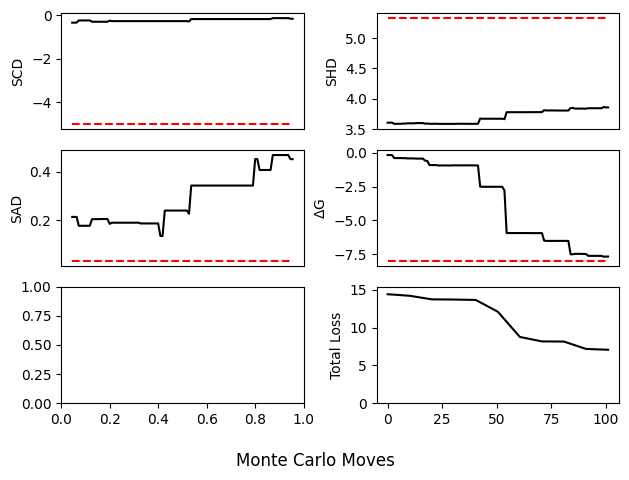

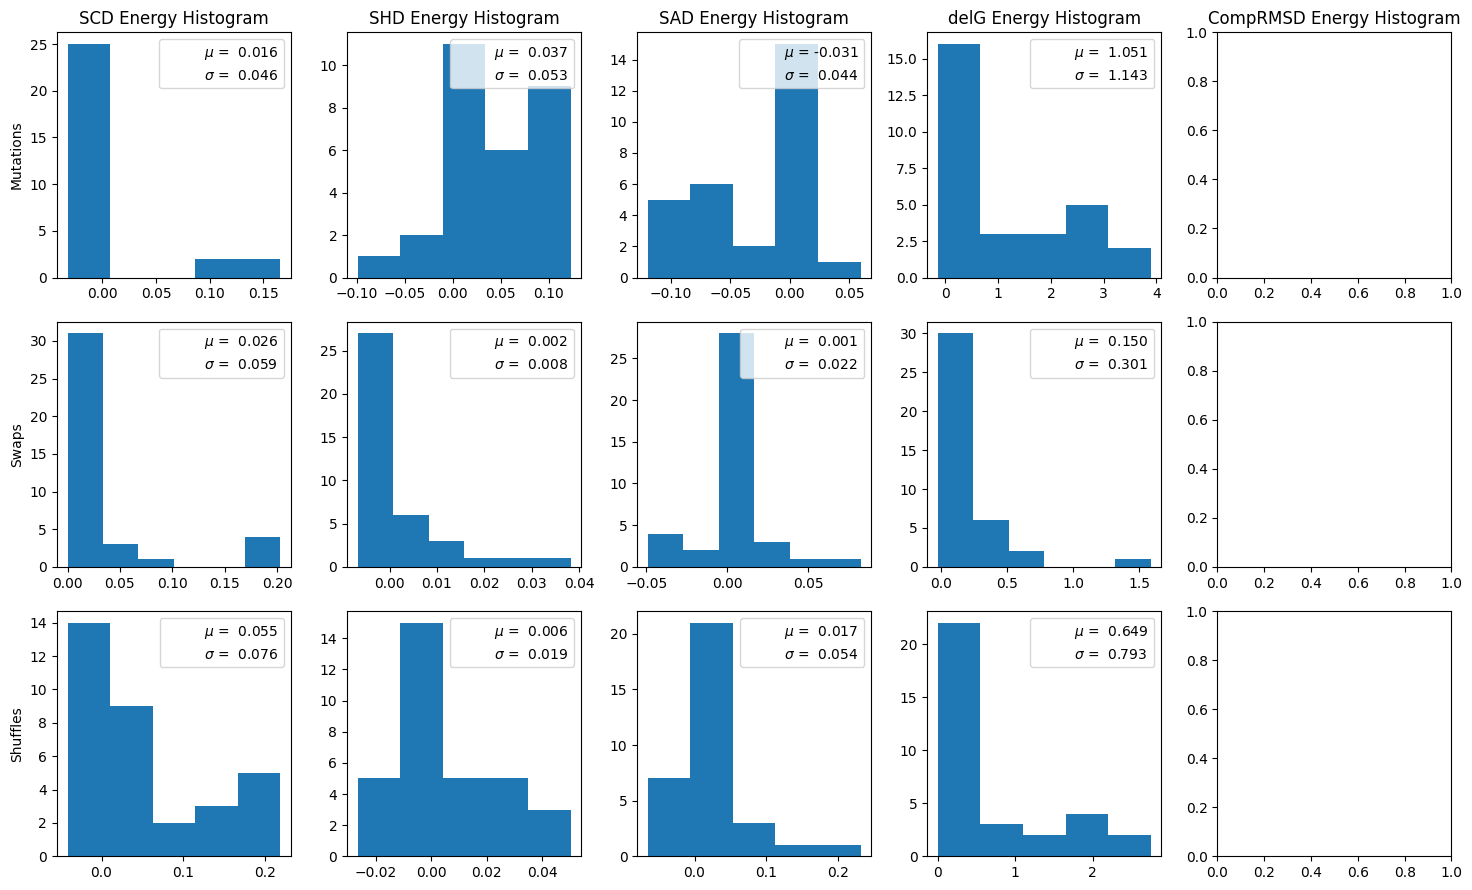

In [ ]:
#@title <b>Plot movement of parameters throughout the loop and save relevant data</b>

from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

for i in range(1, 6):
    if Movement[0, i] != "None":
        Movement[:, i] = Movement[:, i].astype(float)

# Create necessary directories where they doesn't exist
if os.path.exists('Run_Data/Data') == False:
    os.makedirs('Run_Data/Data')

if os.path.exists('Run_Data/Plots') == False:
    os.makedirs('Run_Data/Plots')

if os.path.exists('Run_Data/Data') == False:
    os.makedirs('Run_Data/Data')

if os.path.exists('Run_Data/Data/Energy') == False:
    os.makedirs('Run_Data/Data/Energy')

file_save_FinalCoord = 'Coordinates'
new_save_FinalCoord = copy.deepcopy(file_save_FinalCoord)
count = 0
while os.path.exists(new_save_FinalCoord):
    count += 1
    new_save_FinalCoord = f"Run_Data/Data/{file_save_FinalCoord}{count}"
file_save_FinalCoord = copy.deepcopy(new_save_FinalCoord)

# Save all final sequence information
suffix = count if count else ''  # number indicating specific run
np.savetxt(file_save_FinalCoord, output, fmt='%s', delimiter=',')

print(f"\nAttempted: [Mutations, Swaps, Shuffles, Monte Carlo Moves] = [{mutCount}, {swpCount}, {shfCount}, {iterations}]\n")
print(f"Accepted: [Mutations, Swaps, Shuffles, Monte Carlo Moves] = [{mutAccepted}, {swpAccepted}, {shfAccepted}, {total_Moves}]\n")

if advanced_stats == False:
    [fig, axs] = plt.subplots(3, 2)
    # Plot Movement of Parameters
    if Movement[0, 1] != "None":
        axs[0, 0].plot(Steps, Movement[:, 1], color='k')
        axs[0, 0].plot(Steps, SCD_Goal*np.ones(len(Steps)), linestyle='--', color='r')
        axs[0, 0].set_ylabel(f"SCD")
        axs[0, 0].set_xticks([])
        plt.xlabel('Iterations')

    if Movement[0, 2] != "None":
        axs[0, 1].plot(Steps, Movement[:, 2], color='k')
        axs[0, 1].plot(Steps, SHD_Goal*np.ones(len(Steps)), linestyle='--', color='r')
        axs[0, 1].set_ylabel(f"SHD")
        axs[0, 1].set_xticks([])

    if Movement[0, 3] != "None":
        axs[1, 0].plot(Steps, Movement[:, 3], color='k')
        axs[1, 0].plot(Steps, SAD_Goal*np.ones(len(Steps)), linestyle='--', color='r')
        axs[1, 0].set_ylabel(f"SAD")
        axs[1, 0].set_xticks([])

    if Movement[0, 4] != "None":
        axs[1, 1].plot(Steps, Movement[:, 4], color='k')
        axs[1, 1].plot(Steps, delG_Goal*np.ones(len(Steps)), linestyle='--', color='r')
        axs[1, 1].set_ylabel(f"$\Delta$G")
        axs[1, 1].set_xticks([])

    if Movement[0, 5] != "None":
        axs[2, 0].plot(Steps, Movement[:, 5], color='k')
        axs[2, 0].plot(Steps, Comp_Goal*np.ones(len(Steps)), linestyle='--', color='r')
        axs[2, 0].set_ylabel(f"Comp RMSD")
        axs[2, 0].set_ylim([0, 0.1])

    fig.supxlabel('Monte Carlo Moves')
    plt.tight_layout()
    plt.savefig(f'Run_Data/Plots/Trajectory{suffix}.pdf')
    plt.show()
else:
    np.savetxt(f"Run_Data/Data/MonteCarloData{suffix}", Movement, fmt='%s', delimiter=',')
    np.savetxt(f"Run_Data/Data/Energy/EnergyFrac{suffix}", energyFrac, fmt='%s', delimiter=',')
    np.savetxt(f"Run_Data/Data/Energy/EnergyTot{suffix}", energyTot, fmt='%s', delimiter=',')

    # Parameter and Total Loss Trajectory Figure
    [fig, axs] = plt.subplots(3, 2)

    if Movement[0, 1] != "None":
        axs[0, 0].plot(Steps, Movement[:, 1], color='k')
        axs[0, 0].plot(Steps, SCD_Goal*np.ones(len(Steps)), linestyle='--', color='r')
        axs[0, 0].set_ylabel(f"SCD")
        axs[0, 0].set_xticks([])

    if Movement[0, 2] != "None":
        axs[0, 1].plot(Steps, Movement[:, 2], color='k')
        axs[0, 1].plot(Steps, SHD_Goal*np.ones(len(Steps)), linestyle='--', color='r')
        axs[0, 1].set_ylabel(f"SHD")
        axs[0, 1].set_xticks([])

    if Movement[0, 3] != "None":
        axs[1, 0].plot(Steps, Movement[:, 3], color='k')
        axs[1, 0].plot(Steps, SAD_Goal*np.ones(len(Steps)), linestyle='--', color='r')
        axs[1, 0].set_ylabel(f"SAD")
        axs[1, 0].set_xticks([])

    if Movement[0, 4] != "None":
        axs[1, 1].plot(Steps, Movement[:, 4], color='k')
        axs[1, 1].plot(Steps, delG_Goal*np.ones(len(Steps)), linestyle='--', color='r')
        axs[1, 1].set_ylabel(f"$\Delta$G")
        axs[1, 1].set_xticks([])

    if Movement[0, 5] != "None":
        axs[2, 0].plot(Steps, Movement[:, 5], color='k')
        axs[2, 0].plot(Steps, Comp_Goal*np.ones(len(Steps)), linestyle='--', color='r')
        axs[2, 0].set_ylabel(f"Comp RMSD")
        axs[2, 0].set_ylim([0, 0.1])

    axs[2, 1].plot(Steps[::10], np.nansum(energyTot, axis=1)[::10], color='k')
    axs[2, 1].set_ylim(0, np.nanmax(np.nansum(energyTot, axis=1)[::10]) + 1)
    axs[2, 1].set_ylabel("Total Loss")

    fig.supxlabel('Monte Carlo Moves')
    plt.tight_layout()
    plt.savefig(f'Run_Data/Plots/Trajectory{suffix}.pdf')
    plt.show()

    print("\n")
    # Energy Decomposition Figure
    [fig1, axs1] = plt.subplots(3, 5, figsize=(15, 9))

    for count_graph in range(0, 3):
        energyChangeMoveType = energyChange[np.where(moveTypeTraj.flatten() == count_graph)[0], :]

        if not np.isnan(energyChange[0, 0]):
            axs1[count_graph, 0].hist(energyChangeMoveType[:, 0], bins=int(np.sqrt(len(energyChangeMoveType[:, 0]))))
            meanEnChange0 = np.mean(energyChangeMoveType[:, 0])
            stdEnChange0 = np.std(energyChangeMoveType[:, 0])
            custom_lines0 = [
                Line2D([0], [0], color='none', label=f'$\mu$ = {meanEnChange0: .3f}'),
                Line2D([0], [0], color='none', label=f'$\sigma$ = {stdEnChange0: .3f}')]
            axs1[count_graph, 0].legend(handles=custom_lines0, loc='upper right')

        if not np.isnan(energyChange[0, 1]):
            axs1[count_graph, 1].hist(energyChangeMoveType[:, 1], bins=int(np.sqrt(len(energyChangeMoveType[:, 0]))))
            meanEnChange1 = np.mean(energyChangeMoveType[:, 1])
            stdEnChange1 = np.std(energyChangeMoveType[:, 1])
            custom_lines1 = [
                Line2D([0], [0], color='none', label=f'$\mu$ = {meanEnChange1: .3f}'),
                Line2D([0], [0], color='none', label=f'$\sigma$ = {stdEnChange1: .3f}')]
            axs1[count_graph, 1].legend(handles=custom_lines1, loc='upper right')

        if not np.isnan(energyChange[0, 2]):
            axs1[count_graph, 2].hist(energyChangeMoveType[:, 2], bins=int(np.sqrt(len(energyChangeMoveType[:, 0]))))
            meanEnChange2 = np.mean(energyChangeMoveType[:, 2])
            stdEnChange2 = np.std(energyChangeMoveType[:, 2])
            custom_lines2 = [
                Line2D([0], [0], color='none', label=f'$\mu$ = {meanEnChange2: .3f}'),
                Line2D([0], [0], color='none', label=f'$\sigma$ = {stdEnChange2: .3f}')]
            axs1[count_graph, 2].legend(handles=custom_lines2, loc='upper right')

        if not np.isnan(energyChange[0, 3]):
            axs1[count_graph, 3].hist(energyChangeMoveType[:, 3], bins=int(np.sqrt(len(energyChangeMoveType[:, 0]))))
            meanEnChange3 = np.mean(energyChangeMoveType[:, 3])
            stdEnChange3 = np.std(energyChangeMoveType[:, 3])
            custom_lines3 = [
                Line2D([0], [0], color='none', label=f'$\mu$ = {meanEnChange3: .3f}'),
                Line2D([0], [0], color='none', label=f'$\sigma$ = {stdEnChange3: .3f}')]
            axs1[count_graph, 3].legend(handles=custom_lines3, loc='upper right')

        if not np.isnan(energyChange[0, 4]):
            axs1[count_graph, 4].hist(energyChangeMoveType[:, 4], bins=int(np.sqrt(len(energyChangeMoveType[:, 0]))))
            if count_graph == 0:
                meanEnChange4 = np.mean(energyChangeMoveType[:, 4])
                stdEnChange4 = np.std(energyChangeMoveType[:, 4])
                custom_lines4 = [
                    Line2D([0], [0], color='none', label=f'$\mu$ = {meanEnChange4: .3f}'),
                    Line2D([0], [0], color='none', label=f'$\sigma$ = {stdEnChange4: .3f}')]
                axs1[count_graph, 4].legend(handles=custom_lines4, loc='upper right')

    axs1[0, 0].set_ylabel('Mutations')
    axs1[1, 0].set_ylabel('Swaps')
    axs1[2, 0].set_ylabel('Shuffles')

    axs1[0, 0].set_title('SCD Energy Histogram')
    axs1[0, 1].set_title('SHD Energy Histogram')
    axs1[0, 2].set_title('SAD Energy Histogram')
    axs1[0, 3].set_title('delG Energy Histogram')
    axs1[0, 4].set_title('CompRMSD Energy Histogram')

    plt.tight_layout()
    plt.savefig(f'EnergyDecomposition_Moveset{suffix}.pdf')
    plt.show()